In [381]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import time
import sklearn.discriminant_analysis
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(3)

# Read training data from .csv file
# Data contains of 14 columns in which the first 13 columns are the features and 14th column is the label/class
sourceData = pd.read_csv("Data_for_UCI_named.csv")

# Separate the features and labels from traning data
featureData = sourceData.drop('stabf',axis=1)
labelData = sourceData['stabf']

# Data pre-processing : Standardizing the training data features
featureData = StandardScaler().fit_transform(featureData)

# Mean centre the feature data
mean = np.mean(featureData, axis=0)
featureData = featureData - mean

# Shape of the data
numRows, numCols = featureData.shape

# Separate training and testing sets
trainSize = int(len(featureData) * 0.75)
testSize  = len(featureData) - trainSize
featureDataTrain,featureDataTest = featureData[0:trainSize],featureData[trainSize:]
labelDataTrain,labelDataTest = labelData[0:trainSize],labelData[trainSize:]
ldaPCAErrorMat=[]
ldaPCACompTime=[]
svcPCAErrorMat=[]
svcPCACompTime=[]
ldaFSErrorMat=[]
ldaFSCompTime=[]
svcFSErrorMat=[]
svcFSCompTime=[]

In [382]:
# Apply LDA and compute the classification error and runtime 
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()

# Training
startTime = time.time()
lda.fit(featureDataTrain,labelDataTrain)
endTime=time.time()
trainingRuntime=endTime-startTime

# Testing
startTime = time.time()
prediction = lda.predict(featureDataTest)
endTime=time.time()
testingRuntime = endTime-startTime
classificationError = sum(abs(prediction - labelDataTest))
print(f'Total error with all features using LDA = {classificationError}')
print(f'Percentage of classification error with all features using LDA = {(classificationError/len(labelDataTest))*100}%')
print(f'Total runtime of the LDA classification model = {(trainingRuntime + testingRuntime)*1000} milliseconds')

ldaFSErrorMat.append(classificationError)
ldaFSCompTime.append((trainingRuntime + testingRuntime)*1000)

Total error with all features using LDA = 50
Percentage of classification error with all features using LDA = 2.0%
Total runtime of the LDA classification model = 85.9987735748291 milliseconds


In [383]:
# Apply SVC and compute the classification error and runtime 
svc = SVC(kernel='linear')

# Training
startTime = time.time()
svc.fit(featureDataTrain,labelDataTrain)
endTime=time.time()
trainingRuntime=endTime-startTime

# Testing
startTime = time.time()
prediction = svc.predict(featureDataTest)
endTime=time.time()
testingRuntime = endTime-startTime
classificationError = sum(abs(prediction - labelDataTest))
print(f'Total error with all features using SVC = {classificationError}')
print(f'Percentage of classification error with all features using SVC={(classificationError/len(labelDataTest))*100}%')
print(f'Total runtime of the SVC classification model = {(trainingRuntime + testingRuntime)*1000} milliseconds')

svcFSErrorMat.append(classificationError)
svcFSCompTime.append((trainingRuntime + testingRuntime)*1000)

Total error with all features using SVC = 10
Percentage of classification error with all features using SVC=0.4%
Total runtime of the SVC classification model = 186.02418899536133 milliseconds


In [384]:
#Apply PCA and classify using LDA
#Enter the number to which the dimension needs to be reduced
requiredDimensions=1
i=numCols
plt.rcParams["figure.figsize"] = (6,4)
originalFeatureDataTrain = featureDataTrain
eigValue,eigVector = np.linalg.eig(np.dot(featureDataTrain.T,featureDataTrain))
sortIndex = np.argsort(eigValue)
#Enter the dimesion till which the PCA is to be done
for iteration in range(numCols +1 - requiredDimensions):
    sortedEigVector = np.zeros((numCols,numCols))    
    # sorting the E matrix in increasing order according to its corresponding eigen values
    index = 0
    for i in range(numCols):
        sortedEigVector[:,index] = eigVector[:,sortIndex[i]]
        index = index + 1
    # removing the column from E corresponding to the lowest eigen value
    for j in range(iteration):
        sortedEigVector = np.delete(sortedEigVector, 0, axis=1)
    
    # reduced dimensional data in the score space
    transformedData = np.dot(featureDataTest,sortedEigVector)
    
    #Apply FLD on the PCA data with reduced dimensionality
    classifier = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
    startTime = time.time()
    classifier.fit(transformedData,labelDataTest)
    endTime = time.time()
    trainingTime = endTime - startTime
    startTime = time.time()
    classifiedLabel = classifier.predict(transformedData)
    endTime = time.time()
    testingTime = endTime - startTime
    
    #Compute the classification error by comparing the PCA classified labels with the original labelled data
    classificationerror = sum(abs(classifiedLabel - labelDataTest))
    ldaPCAErrorMat.append(classificationerror)
    ldaPCACompTime.append((trainingTime + testingTime)*1000)
    
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    arrlabelDataTest = np.array(labelDataTest)
    for k in range(len(labelDataTest)):
        if np.array(arrlabelDataTest[k]) == classifiedLabel[k]:
            if arrlabelDataTest[k] == 1: 
                tp += 1
            else: 
                tn += 1
        else: 
            if arrlabelDataTest[k] == 1: 
                fp += 1
            else: 
                fn += 1
    our_confusion_matrix = [
        [fp, tp],
        [tn, fn]
    ]
    our_confusion_matrix = np.array(our_confusion_matrix)
    print(f'Confusion matrix for {numCols -iteration} dimensional data = \n {our_confusion_matrix}')
for i in range(numCols-1,-1,-1):
    print("Classification error with " + str(i+1) + " features = " + str(ldaPCAErrorMat[numCols - i-1]))
    print("Computation time for " + str(i+1) + " features = " + str(ldaPCACompTime[numCols - i-1]) + " milliseconds")


Confusion matrix for 13 dimensional data = 
 [[   4  896]
 [1543   57]]
Confusion matrix for 12 dimensional data = 
 [[   5  895]
 [1543   57]]
Confusion matrix for 11 dimensional data = 
 [[ 118  782]
 [1474  126]]
Confusion matrix for 10 dimensional data = 
 [[ 118  782]
 [1475  125]]
Confusion matrix for 9 dimensional data = 
 [[ 113  787]
 [1477  123]]
Confusion matrix for 8 dimensional data = 
 [[ 114  786]
 [1474  126]]
Confusion matrix for 7 dimensional data = 
 [[ 115  785]
 [1474  126]]
Confusion matrix for 6 dimensional data = 
 [[ 116  784]
 [1473  127]]
Confusion matrix for 5 dimensional data = 
 [[ 118  782]
 [1465  135]]
Confusion matrix for 4 dimensional data = 
 [[ 118  782]
 [1466  134]]
Confusion matrix for 3 dimensional data = 
 [[ 121  779]
 [1465  135]]
Confusion matrix for 2 dimensional data = 
 [[ 120  780]
 [1465  135]]
Confusion matrix for 1 dimensional data = 
 [[ 879   21]
 [1571   29]]
Classification error with 13 features = 61
Computation time for 13 featur

In [385]:
#Apply PCA and classify using SVC

#Enter the number to which the dimension needs to be reduced
requiredDimensions=1
i=numCols
plt.rcParams["figure.figsize"] = (6,4)
originalFeatureDataTrain = featureDataTrain
eigValue,eigVector = np.linalg.eig(np.dot(featureDataTrain.T,featureDataTrain))
sortIndex = np.argsort(eigValue)
#Enter the dimesion till which the PCA is to be done
for iteration in range(numCols +1 - requiredDimensions):
    sortedEigVector = np.zeros((numCols,numCols))    
    # sorting the E matrix in increasing order according to its corresponding eigen values
    index = 0
    for i in range(numCols):
        sortedEigVector[:,index] = eigVector[:,sortIndex[i]]
        index = index + 1
    # removing the column from E corresponding to the lowest eigen value
    for j in range(iteration):
        sortedEigVector = np.delete(sortedEigVector, 0, axis=1)
    # reduced dimensional data in the score space
    transformedData = np.dot(featureDataTest,sortedEigVector)
    #Apply SVC on the PCA data with reduced dimensionality
    classifier = SVC(kernel='linear')
    startTime = time.time()
    classifier.fit(transformedData,labelDataTest)
    endTime = time.time()
    trainingTime = endTime - startTime
    startTime = time.time()
    classifiedLabel = classifier.predict(transformedData)
    endTime = time.time()
    testingTime = endTime - startTime
    
    #Compute the classification error by comparing the PCA classified labels with the original labelled data
    classificationerror = sum(abs(classifiedLabel - labelDataTest))
    svcPCAErrorMat.append(classificationerror)
    svcPCACompTime.append((trainingTime + testingTime)*1000)
    i=i-1
    
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    arrlabelDataTest = np.array(labelDataTest)
    for k in range(len(labelDataTest)):
        if np.array(arrlabelDataTest[k]) == classifiedLabel[k]:
            if arrlabelDataTest[k] == 1: 
                tp += 1
            else: 
                tn += 1
        else: 
            if arrlabelDataTest[k] == 1: 
                fp += 1
            else: 
                fn += 1
    our_confusion_matrix = [
        [fp, tp],
        [tn, fn]
    ]
    our_confusion_matrix = np.array(our_confusion_matrix)
    print(f'Confusion matrix for {numCols -iteration} dimensional data = \n {our_confusion_matrix}')
for i in range(numCols-1,-1,-1):
    print("Classification error with " + str(i+1) + " features = " + str(svcPCAErrorMat[numCols - i-1]))
    print("Computation time for " + str(i+1) + " features = " + str(svcPCACompTime[numCols - i-1]) + " milliseconds")

Confusion matrix for 13 dimensional data = 
 [[   3  897]
 [1593    7]]
Confusion matrix for 12 dimensional data = 
 [[   3  897]
 [1593    7]]
Confusion matrix for 11 dimensional data = 
 [[ 141  759]
 [1496  104]]
Confusion matrix for 10 dimensional data = 
 [[ 144  756]
 [1498  102]]
Confusion matrix for 9 dimensional data = 
 [[ 142  758]
 [1494  106]]
Confusion matrix for 8 dimensional data = 
 [[ 137  763]
 [1496  104]]
Confusion matrix for 7 dimensional data = 
 [[ 135  765]
 [1489  111]]
Confusion matrix for 6 dimensional data = 
 [[ 139  761]
 [1489  111]]
Confusion matrix for 5 dimensional data = 
 [[ 140  760]
 [1493  107]]
Confusion matrix for 4 dimensional data = 
 [[ 141  759]
 [1490  110]]
Confusion matrix for 3 dimensional data = 
 [[ 138  762]
 [1489  111]]
Confusion matrix for 2 dimensional data = 
 [[ 138  762]
 [1489  111]]
Confusion matrix for 1 dimensional data = 
 [[ 900    0]
 [1600    0]]
Classification error with 13 features = 10
Computation time for 13 featur

In [386]:
#Apply backward search and classify using LDA
error = np.zeros(numCols)

j=numCols
newFeatureDataTrain = featureDataTrain
newFeatureDataTest = featureDataTest
for dimension in range(numCols-requiredDimensions):
    error = 10000*np.ones(j)
    
    for feature in range(j):
        selectedData = np.delete(newFeatureDataTrain, feature, axis=1)
        classifier = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
        classifier.fit(selectedData,labelDataTrain)
        classifiedLabel = classifier.predict(selectedData)
        error[feature]= sum(abs(classifiedLabel - labelDataTrain))
    j=j-1
    
    newFeatureDataTrain = np.delete(newFeatureDataTrain, np.argmin(error), axis=1)
    newFeatureDataTest = np.delete(newFeatureDataTest, np.argmin(error), axis=1)

    classifier = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
    startTime = time.time()
    classifier.fit(newFeatureDataTrain,labelDataTrain)
    endTime = time.time()
    trainingTime = endTime - startTime
    startTime = time.time()
    classifiedLabel = classifier.predict(newFeatureDataTest)
    endTime = time.time()
    ldaFSErrorMat.append(sum(abs(classifiedLabel - labelDataTest)))
    testingTime = endTime - startTime
    ldaFSCompTime.append((trainingTime + testingTime)*1000)
    
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    arrlabelDataTest = np.array(labelDataTest)
    for k in range(len(labelDataTest)):
        if np.array(arrlabelDataTest[k]) == classifiedLabel[k]:
            if arrlabelDataTest[k] == 1: 
                tp += 1
            else: 
                tn += 1
        else: 
            if arrlabelDataTest[k] == 1: 
                fp += 1
            else: 
                fn += 1
    our_confusion_matrix = [
        [fp, tp],
        [tn, fn]
    ]
    our_confusion_matrix = np.array(our_confusion_matrix)
    print(f'Confusion matrix for {numCols -dimension-1} dimensional data = \n {our_confusion_matrix}')
for i in range(numCols-1,-1,-1):
    print("Classification error with " + str(i+1) + " features = " + str(ldaFSErrorMat[numCols - i-1]))
    print("Computation time for " + str(i+1) + " features = " + str(ldaFSCompTime[numCols - i-1]) + " milliseconds")


Confusion matrix for 12 dimensional data = 
 [[   2  898]
 [1551   49]]
Confusion matrix for 11 dimensional data = 
 [[   0  900]
 [1551   49]]
Confusion matrix for 10 dimensional data = 
 [[   0  900]
 [1549   51]]
Confusion matrix for 9 dimensional data = 
 [[   0  900]
 [1550   50]]
Confusion matrix for 8 dimensional data = 
 [[   0  900]
 [1550   50]]
Confusion matrix for 7 dimensional data = 
 [[   0  900]
 [1550   50]]
Confusion matrix for 6 dimensional data = 
 [[   0  900]
 [1549   51]]
Confusion matrix for 5 dimensional data = 
 [[   0  900]
 [1551   49]]
Confusion matrix for 4 dimensional data = 
 [[   0  900]
 [1550   50]]
Confusion matrix for 3 dimensional data = 
 [[   0  900]
 [1554   46]]
Confusion matrix for 2 dimensional data = 
 [[   0  900]
 [1553   47]]
Confusion matrix for 1 dimensional data = 
 [[   0  900]
 [1552   48]]
Classification error with 13 features = 50
Computation time for 13 features = 85.9987735748291 milliseconds
Classification error with 12 features

In [387]:
#Apply backward search and classify using SVC
error = np.zeros(numCols)

j=numCols
newFeatureDataTrain = featureDataTrain
newFeatureDataTest = featureDataTest
for dimension in range(numCols-requiredDimensions):
    error = 10000*np.ones(j)
    
    for feature in range(j):
        selectedData = np.delete(newFeatureDataTrain, feature, axis=1)
        classifier = SVC(kernel='linear')
        classifier.fit(selectedData,labelDataTrain)
        classifiedLabel = classifier.predict(selectedData)
        error[feature]= sum(abs(classifiedLabel - labelDataTrain))
    j=j-1
    
    newFeatureDataTrain = np.delete(newFeatureDataTrain, np.argmin(error), axis=1)
    newFeatureDataTest = np.delete(newFeatureDataTest, np.argmin(error), axis=1)

    classifier = SVC(kernel='linear')
    startTime = time.time()
    classifier.fit(newFeatureDataTrain,labelDataTrain)
    endTime = time.time()
    trainingTime = endTime - startTime
    startTime = time.time()
    classifiedLabel = classifier.predict(newFeatureDataTest)
    endTime = time.time()
    svcFSErrorMat.append(sum(abs(classifiedLabel - labelDataTest)))
    testingTime = endTime - startTime
    svcFSCompTime.append((trainingTime + testingTime)*1000)
    
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    arrlabelDataTest = np.array(labelDataTest)
    for k in range(len(labelDataTest)):
        if np.array(arrlabelDataTest[k]) == classifiedLabel[k]:
            if arrlabelDataTest[k] == 1: 
                tp += 1
            else: 
                tn += 1
        else: 
            if arrlabelDataTest[k] == 1: 
                fp += 1
            else: 
                fn += 1
    our_confusion_matrix = [
        [fp, tp],
        [tn, fn]
    ]
    our_confusion_matrix = np.array(our_confusion_matrix)
    print(f'Confusion matrix for {numCols -dimension-1} dimensional data = \n {our_confusion_matrix}')
for i in range(numCols-1,-1,-1):
    print("Classification error with " + str(i+1) + " features = " + str(svcFSErrorMat[numCols - i-1]))
    print("Computation time for " + str(i+1) + " features = " + str(svcFSCompTime[numCols - i-1]) + " milliseconds")

Confusion matrix for 12 dimensional data = 
 [[   6  894]
 [1597    3]]
Confusion matrix for 11 dimensional data = 
 [[   8  892]
 [1598    2]]
Confusion matrix for 10 dimensional data = 
 [[   8  892]
 [1598    2]]
Confusion matrix for 9 dimensional data = 
 [[   8  892]
 [1597    3]]
Confusion matrix for 8 dimensional data = 
 [[   6  894]
 [1599    1]]
Confusion matrix for 7 dimensional data = 
 [[   5  895]
 [1599    1]]
Confusion matrix for 6 dimensional data = 
 [[   5  895]
 [1599    1]]
Confusion matrix for 5 dimensional data = 
 [[   5  895]
 [1599    1]]
Confusion matrix for 4 dimensional data = 
 [[   4  896]
 [1600    0]]
Confusion matrix for 3 dimensional data = 
 [[   3  897]
 [1600    0]]
Confusion matrix for 2 dimensional data = 
 [[   3  897]
 [1600    0]]
Confusion matrix for 1 dimensional data = 
 [[   3  897]
 [1600    0]]
Classification error with 13 features = 10
Computation time for 13 features = 186.02418899536133 milliseconds
Classification error with 12 featur

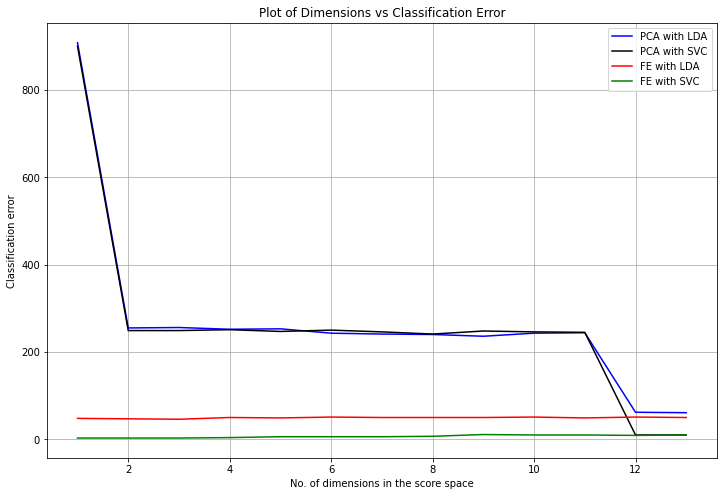

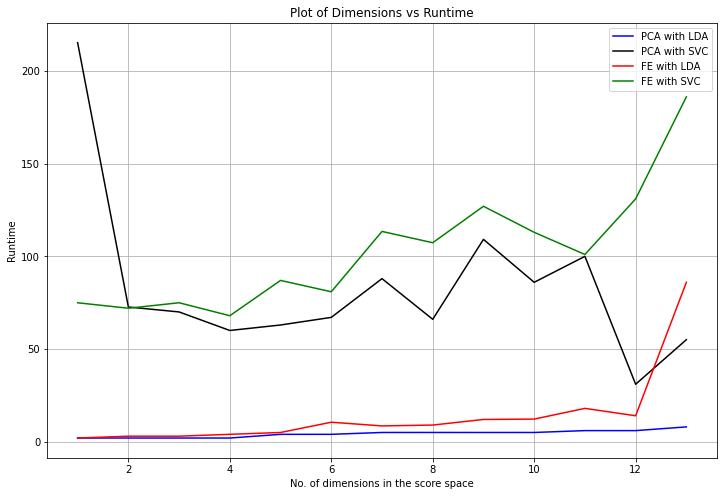

In [388]:
retainedvalue=np.array(range(numCols,0,-1))
plt.rcParams["figure.figsize"] = (12,8)
plt.gca().set_title("Plot of Dimensions vs Classification Error")
plt.plot(retainedvalue,ldaPCAErrorMat, color="blue", label='PCA with LDA')
plt.plot(retainedvalue,svcPCAErrorMat, color="black", label='PCA with SVC')
plt.plot(retainedvalue,ldaFSErrorMat, color="red", label='FE with LDA')
plt.plot(retainedvalue,svcFSErrorMat, color="green", label='FE with SVC')
plt.legend()
plt.xlabel('No. of dimensions in the score space')
plt.ylabel('Classification error')
plt.grid()
plt.show()

#Plot of Dimensions vs runtime
retainedvalue=np.array(range(numCols,0,-1))
plt.rcParams["figure.figsize"] = (12,8)
plt.gca().set_title("Plot of Dimensions vs Runtime")
plt.plot(retainedvalue,ldaPCACompTime, color="blue", label='PCA with LDA')
plt.plot(retainedvalue,svcPCACompTime, color="black", label='PCA with SVC')
plt.plot(retainedvalue,ldaFSCompTime, color="red", label='FE with LDA')
plt.plot(retainedvalue,svcFSCompTime, color="green", label='FE with SVC')
plt.legend()
plt.xlabel('No. of dimensions in the score space')
plt.ylabel('Runtime')
plt.grid()
plt.show()